shape: (50000, 2)
k=5 -> umass: -1.287
k=8 -> umass: -1.459
k=10 -> umass: -1.518
k=12 -> umass: -1.520
melhor k: 5
melhor C: {'C': 2.0}
acc=0.896 prec=0.890 rec=0.903 f1=0.897 auc=0.961
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6250
           1       0.89      0.90      0.90      6250

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



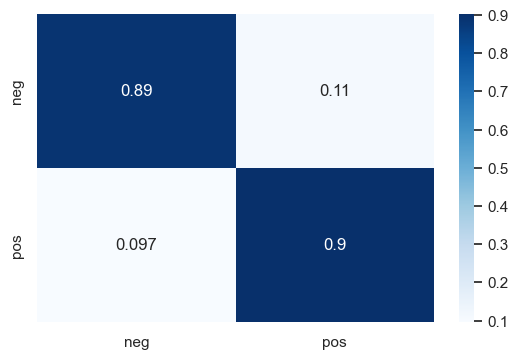

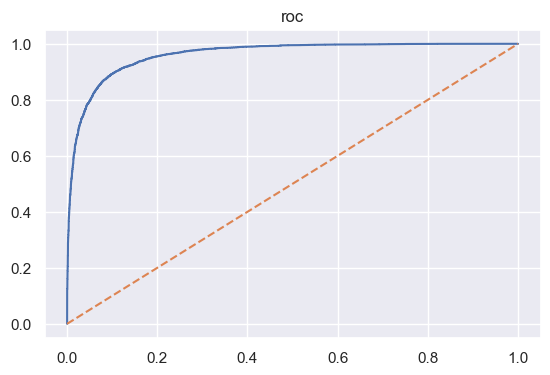

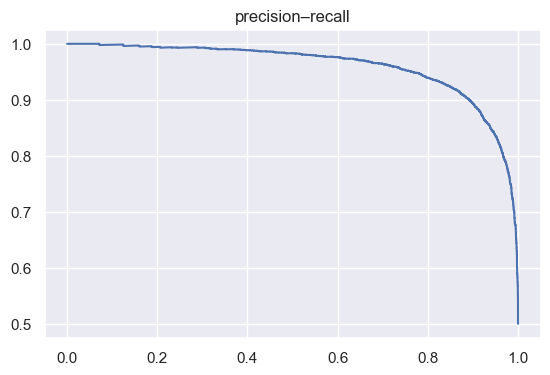

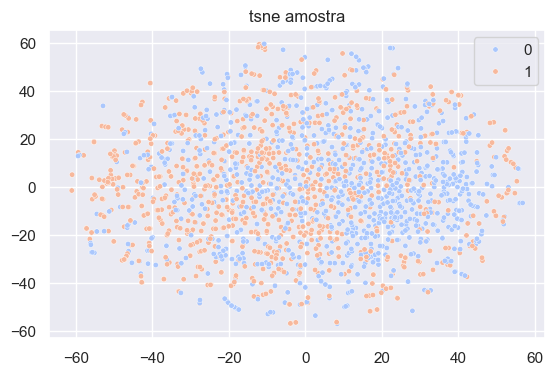

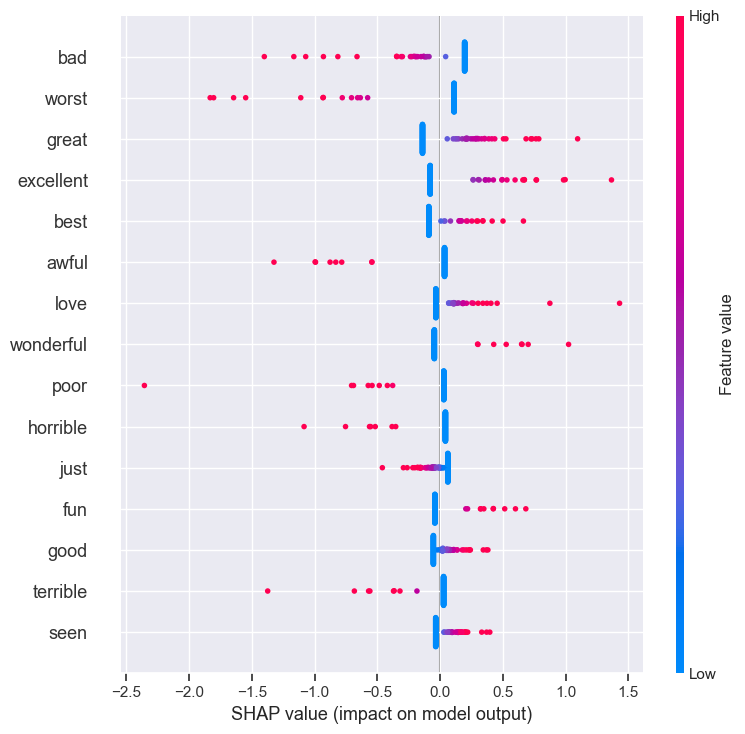

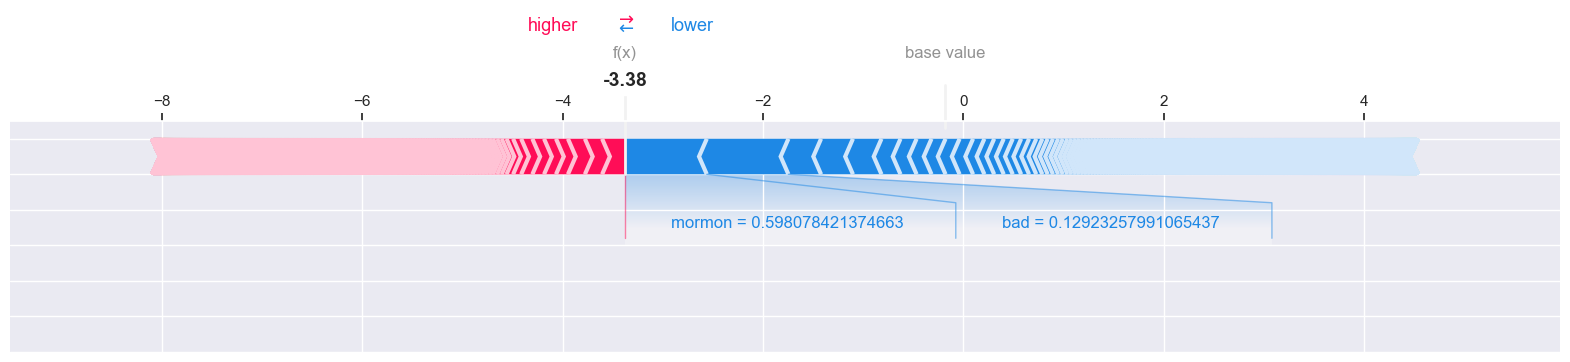

conclusoes:
- lda: k escolhido por maior coerencia umass
- logistic regression com tf-idf obteve bom equilibrio (f1, auc)
- tsne mostra separacao parcial das classes
- shap indica tokens mais influentes e explica previsoes individuais


In [ ]:
import re, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")
sns.set(context="notebook"); plt.rcParams["figure.figsize"] = (6.4,4.0); plt.rcParams["axes.grid"] = True
R = 42

# questao 1: features tf-idf
df = pd.read_csv("IMDBDataset.csv")
def clean(s):
    s = re.sub(r"<br\s*/?>", " ", str(s))
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip().lower()
df = df.dropna(subset=["review","sentiment"]).copy()
df["review"] = df["review"].apply(clean)
df["sentiment"] = df["sentiment"].map({"positive":1,"negative":0}).astype(int)
print("shape:", df.shape)

tfidf = TfidfVectorizer(max_features=8000, stop_words="english", ngram_range=(1,2), min_df=3, max_df=0.90)
X_tfidf = tfidf.fit_transform(df["review"])
count_v = CountVectorizer(max_features=8000, stop_words="english", min_df=5, max_df=0.95)
X_count = count_v.fit_transform(df["review"])
terms = np.array(count_v.get_feature_names_out())
y = df["sentiment"].values

# questao 2: lda e coerência
def umass_coherence(lda_model, X_cnt, topn=10, eps=1.0):
    comp = lda_model.components_
    top_idx = np.argsort(comp, axis=1)[:, ::-1][:, :topn]
    Xb = (X_cnt[:4000]!=0).astype(int)
    D_w = np.asarray(Xb.sum(axis=0)).ravel()
    C = Xb.T @ Xb
    s = []
    for row in top_idx:
        v = 0.0; c = 0
        for i in range(1, len(row)):
            wi = row[i]
            for j in range(i):
                wj = row[j]
                v += np.log((C[wi, wj] + eps) / (D_w[wj] + eps))
                c += 1
        s.append(v / max(c,1))
    return float(np.mean(s))

Ks = [5,8,10,12]; scores = {}
for k in Ks:
    m = LatentDirichletAllocation(n_components=k, random_state=R)
    m.fit(X_count)
    scores[k] = umass_coherence(m, X_count)
    print(f"k={k} -> umass: {scores[k]:.3f}")
best_k = max(scores, key=scores.get); print("melhor k:", best_k)
lda = LatentDirichletAllocation(n_components=best_k, random_state=R)
lda.fit(X_count)

# questao 3: classificação com tf-idf
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=R, stratify=y)
grid = {"C":[0.5,1.0,2.0,4.0]}
clf = LogisticRegression(max_iter=1000, solver="liblinear")
gs  = GridSearchCV(clf, grid, scoring="f1", cv=StratifiedKFold(5, shuffle=True, random_state=R), n_jobs=-1)
gs.fit(X_train, y_train); best = gs.best_estimator_
print("melhor C:", gs.best_params_)
y_pred  = best.predict(X_test); y_proba = best.predict_proba(X_test)[:,1]

# questao 4: avaliação
acc = accuracy_score(y_test, y_pred); prec = precision_score(y_test, y_pred); rec = recall_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred); auc_ = roc_auc_score(y_test, y_proba)
print(f"acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} auc={auc_:.3f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred); cmn = cm / cm.sum(axis=1, keepdims=True)
sns.heatmap(cmn, annot=True, cmap="Blues", xticklabels=["neg","pos"], yticklabels=["neg","pos"]); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba); prec_c, rec_c, _ = precision_recall_curve(y_test, y_proba)
plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.title("roc"); plt.show()
plt.plot(rec_c,prec_c); plt.title("precision–recall"); plt.show()

# questao 5: tsne
n = min(2000, X_tfidf.shape[0]); idx = np.random.RandomState(R).choice(X_tfidf.shape[0], n, replace=False)
Z = TSNE(n_components=2, random_state=R).fit_transform(X_tfidf[idx].toarray())
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=y[idx], palette="coolwarm", s=15); plt.title("tsne amostra"); plt.show()

# questao 6: shap
shap.initjs()
masker = shap.maskers.Independent(X_train)
explainer = shap.LinearExplainer(best, masker=masker)
m = min(120, X_test.shape[0]); X_sub = X_test[:m]
sv = explainer.shap_values(X_sub)
shap.summary_plot(sv, X_sub.toarray(), feature_names=tfidf.get_feature_names_out(), max_display=15)
shap.force_plot(explainer.expected_value, sv[0], X_sub[0].toarray(), feature_names=tfidf.get_feature_names_out(), matplotlib=True)

# questao 7: análise final
print("conclusoes:")
print("- lda: k escolhido por maior coerencia umass")
print("- logistic regression com tf-idf obteve bom equilibrio (f1, auc)")
print("- tsne mostra separacao parcial das classes")
print("- shap indica tokens mais influentes e explica previsoes individuais")